# Process tables

Process data tables from various sources and save them in the same format.

The saved tables are dictionaries with data[column_name] = (n,) numpy array containing planet-level data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from util import *

import sys
sys.path.insert(0, './forecaster/') # https://github.com/chenjj2/forecaster, adapted for python3
import mr_forecast as mr

# CKS (transit; Weiss+2018)

Use Chen & Kipping 2016 mass-radius relation. Also save a copy using Weiss+2018 mass-radius relation.

In [2]:
# read CKS data
d = (6, 8, 9, 13, 6, 5, 7, 6, 14, 14, 16, 14, 15, 14, 14)
d = np.array(d)+1
data = np.genfromtxt("./tables/CKS/table1.dat", delimiter = d, dtype=None)
data[0]

/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_99066/2837829181.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt("./tables/CKS/table1.dat", delimiter = d, dtype=None)


(b'K00041 ', 6521045, b'K00041.02 ', b'Kepler-100 b  ', 1.107, 1.55, 23.331, 0.5134, 6.88706037, 1.35499223, b'|0.2359621740790 ', 1186.84221864, 0., 0., 0.)

In [3]:
data_out = {}
data_out['system'] = np.array([d[0].decode('utf-8').strip() for d in data])
data_out['m_star_msun'] = np.array([d[4] for d in data])
data_out['r_p_rearth'] = np.array([d[9] for d in data])
data_out['r_p_err_rearth'] = np.array([float(d[10].decode('utf-8')[1:]) for d in data])
data_out['period_day'] = np.array([d[8] for d in data])

data_out['a_p_au'] = (data_out['period_day']/365.25)**(2/3) * data_out['m_star_msun']**(1/3)

In [5]:
# estimate mass using forecaster (Chen & Kipping 2016)

result = [mr.Rstat2M(r1, rerr1) for r1,rerr1 in zip(data_out['r_p_rearth'],data_out['r_p_err_rearth'])]
# the estimate may fail by chance. redo estimate for unlucky data
while None in result:
    for i,x in enumerate(result):
        if x is None:
            result[i] = mr.Rstat2M(data_out['r_p_rearth'][i], data_out['r_p_err_rearth'][i])

/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_99066/3691670450.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result = [mr.Rstat2M(r1, rerr1) for r1,rerr1 in zip(data_out['r_p_rearth'],data_out['r_p_err_rearth'])]


Radius range out of model expectation. Returning None.


/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_99066/3691670450.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result[i] = mr.Rstat2M(data_out['r_p_rearth'][i], data_out['r_p_err_rearth'][i])


In [6]:
data_out['m_p_mearth'] = np.array([d[0] for d in result])
data_out['log_m_p_err'] = np.array([np.log((d[0]+d[1])/(d[0]-d[2]))/2 for d in result])
r_CK16 = data_out['r_p_rearth']
m_CK16 = data_out['m_p_mearth']

In [7]:
pickle.dump(data_out,open('./data/CKS.pkl','wb'))

In [8]:
# redo mass estimate with Weiss+2018 mass-radius relation

# taken from Weiss+2018, based on Weiss & Marcy 2014 and Weiss+2013
# this choice is in accordance with the CKS paper
def radius_to_mass(r):
    if r<1.5:
        rho = 2.43 + 3.39*r
        m = (rho/5.51)*r**3
    elif r<4:
        m = 2.69 * r**0.93
    elif r<9:
        m = 0.86 * r**1.89
    else:
        m = 100
    return m

del data_out['m_p_mearth']
del data_out['log_m_p_err']
data_out['m_p_mearth'] = np.array([radius_to_mass(r1) for r1 in data_out['r_p_rearth']])

In [9]:
pickle.dump(data_out,open('./data/CKS_W18.pkl','wb'))

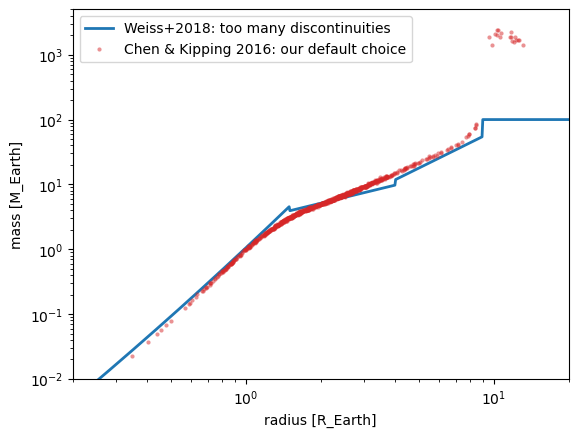

In [24]:
# compare the two mass-radius relations
r = np.logspace(-1,2,1000)
m = [radius_to_mass(r1) for r1 in r]
plt.plot(r, m, color='tab:blue', lw=2)
plt.plot(r_CK16, m_CK16, '.', color='tab:red', alpha=.5, mew=0)
plt.xscale('log'); plt.xlim(0.2,20)
plt.yscale('log'); plt.ylim(1e-2,5e3)
plt.xlabel('radius [R_Earth]')
plt.ylabel('mass [M_Earth]')
plt.legend(['Weiss+2018: too many discontinuities', 'Chen & Kipping 2016: our default choice'])
plt.show()

# CLS (RV)

In [11]:
data = np.genfromtxt("./tables/CLS/table3.txt", dtype=None, skip_header=5, delimiter='\t')
data[0]

/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_99066/2228081910.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt("./tables/CLS/table3.txt", dtype=None, skip_header=5, delimiter='\t')


array([b'HD 104067 b', b'HD 104067 b', b'${0.202}_{-0.017}^{+0.017}$',
       b'${0.2673}_{-0.0033}^{+0.0032}$', b'${0.247}_{-0.082}^{+0.080}$',
       b'Vogt et al. (2000)', b'False'], dtype='|S33')

In [12]:
data_out = {}

def strip_name(s):
    s = s.decode('utf-8').strip()
    if s[-1] in 'abcdefgh': s = s[:-1]
    s = s.strip()
    return s
data_out['system'] = np.array([strip_name(d[0]) for d in data])

def get_num(s):
    s = s.decode('utf-8')
    s = s[2:]
    i = s.find('}')
    s = s[:i]
    return float(s)
def get_err(s):
    s = s.decode('utf-8')
    s = s[2:]
    i = s.find('{')
    s = s[i+1:]
    i = s.find('}')
    err_low = float(s[:i])
    i = s.find('{')
    s = s[i+1:]
    i = s.find('}')
    err_hi = float(s[:i])
    return err_low, err_hi
data_out['m_p_mearth'] = np.array([get_num(d[2]) for d in data]) * Mjup/Mearth
data_out['m_p_mearth_low'] = data_out['m_p_mearth']+np.array([get_err(d[2])[0] for d in data]) * Mjup/Mearth
data_out['m_p_mearth_high'] = data_out['m_p_mearth']+np.array([get_err(d[2])[1] for d in data]) * Mjup/Mearth
data_out['a_p_au'] = np.array([get_num(d[3]) for d in data])

In [13]:
d = np.array([3,9,6,5,6,5,5,5,6,5,5,5,7,6,8])+1
data_stars = np.genfromtxt("./tables/CLS/table2.txt", dtype=None, skip_header=29, delimiter=d)
star_names = [d[1].decode('utf-8').strip() for d in data_stars]
star_mass = [d[-5] for d in data_stars]
def get_abbr(s):
    s=s.replace('HD ','')
    s=s.replace('HIP ','hip')
    s=s.replace('BD-','bd-')
    s=s.replace('GL ','gl')
    s=s.replace('A','a')
    s=s.replace('B','b')
    return s
data_out['m_star_msun'] = np.array([star_mass[star_names.index(get_abbr(s))] for s in data_out['system']])

/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_99066/515943769.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data_stars = np.genfromtxt("./tables/CLS/table2.txt", dtype=None, skip_header=29, delimiter=d)


In [14]:
pickle.dump(data_out,open('./data/CLS.pkl','wb'))

# Mishra+2023 (catalogue of systems with 4+ planets)

In [15]:
data_txt = open("./tables/M23/table1.dat","r").readlines()
data_txt[0][0:10] # name

'Sun       '

In [16]:
data_txt[0][69:87] # stellar mass

'1.0               '

In [17]:
data_txt[0][329:433] # planet mass

'   0.0552735834    0.814998785    1.00000088    0.107446887 317.828379  95.1578521 14.5357332 17.1477471'

In [18]:
data_txt[0][556:646] # planet radius

' 0.38264217 0.94884056  1.00000574 0.53247676 11.20898073 9.45892978 4.00730625 3.95493956'

In [19]:
data_txt[0][769:864] # planet a

' 0.38709927  0.72333566  1.00000261  1.52371034  5.202887    9.53667594 19.18916464 30.06992276'

In [20]:
data_txt = data_txt[:-1] # stip last empty line
for i in range(len(data_txt)):
    data_txt[i] = data_txt[i].replace('---','nan')

In [21]:
data_out = {}
data_out['system'] = np.concatenate([[d[0:10].strip()]*int(float(d[65:68])) for d in data_txt])
data_out['m_star_msun'] = np.concatenate([[float(d[69:87])]*int(float(d[65:68])) for d in data_txt])
data_out['m_p_mearth'] = np.concatenate([np.fromstring(d[329:433], dtype='float', sep=' ') for d in data_txt])
data_out['r_p_rearth'] = np.concatenate([np.fromstring(d[556:646], dtype='float', sep=' ') for d in data_txt])
data_out['a_p_au'] = np.concatenate([np.fromstring(d[769:864], dtype='float', sep=' ') for d in data_txt])

In [22]:
pickle.dump(data_out,open('./data/M23.pkl','wb'))